# Overview
The project inspects Travel Insurance Prediction Data from Kaggle. 

The primary objectives are to clean the data, perform exploratory data analysis, statistical analysis, and apply various machine learning models for target variable TravelInsurance prediction.

## Dataset
Dataset can be downloaded from [Kaggle](https://www.kaggle.com/datasets/tejashvi14/travel-insurance-prediction-data).

In [209]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn import svm 
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
import warnings

import seaborn as sns

import textblob
from unidecode import unidecode

pd.plotting.register_matplotlib_converters()
%matplotlib inline

In [210]:
"""Setting graph parameters"""
sns.set_theme(style='whitegrid')
sns.set_palette('rocket')

In [211]:
%load_ext autoreload
%autoreload 2
from tools import helpingtool

warnings.filterwarnings("ignore", category=UserWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Preparation
Downloaded data has 1987 instances.

In [212]:
travel_insurance = helpingtool.csv_download(
    r"..\Travel_Insurance\TravelInsurancePrediction.csv")
travel_insurance.shape

(1987, 9)

## Splitting Data 
Splitting data into 3 subsets:
* train (training) 
* validation - model tuning vs unseen data
* test - picking out the best model, where performance is checked on unseen data

In [213]:
insurance = helpingtool.dummy_columns(travel_insurance, [
                                      'Employment Type', 'GraduateOrNot', 'FrequentFlyer', 'EverTravelledAbroad'])

insurance.rename(columns={'Employment Type_Government Sector': 'Government_Employee',

                          'GraduateOrNot': 'Graduate'

                          }, inplace=True)

insurance.drop(
    columns=['Employment Type_Private Sector/Self Employed'], inplace=True)

## Weights
Training data will not have Weights added to prevent data spilling. But Validation and Testing will have weights available as part of scoring. <br>
Weighs are constructed from aggregating rows instances. After aggregation, data has 1249 instances.

In [214]:
insurance_weight = insurance.groupby(['Age', 'AnnualIncome', 'FamilyMembers', 'ChronicDiseases',
                                      'TravelInsurance', 'Government_Employee', 'Graduate',
                                      'FrequentFlyer',
                                      'EverTravelledAbroad'
                                      ]).size().reset_index(name='Weights')
insurance_weight.shape

(1249, 10)

Data split is done on the new insurance_weight dataset. After splitting, 'weights' column is removed from X: training, validation and test.

In [215]:
X = insurance_weight.drop('TravelInsurance', axis=1)
y = insurance_weight['TravelInsurance']
weights = insurance_weight['Weights']

(X_train, X_vt, y_train, y_vt, weights_train, weights_vt) = train_test_split(
    X, y, weights, test_size=0.4, random_state=42, stratify=y
)

(X_validation, X_test, y_validation, y_test, weights_validation, weights_test) = train_test_split(
    X_vt, y_vt, weights_vt, test_size=0.5, random_state=42, stratify=y_vt
)

In [216]:
X_train_with_weights = X_train

Making sure not to spill over data into training data.

In [217]:
X_train.drop(columns='Weights', inplace=True)
X_validation.drop(columns='Weights', inplace=True)
X_test.drop(columns='Weights', inplace=True)
X.drop(columns='Weights', inplace=True)

Preparing scaled data

In [218]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.fit_transform(X_validation)
X_test_scaled = scaler.fit_transform(X_test)

# Models
## Various machine learning models with default parameters
All models use weights for validation data.
### Linear Support Vector Machine

In [219]:
svm_linear = svm.LinearSVC(C=0.1, dual=False)
svm_linear.fit(X_train_scaled, y_train)

helpingtool.accuracy_score_test_val(
    svm_linear, X_train_scaled, y_train, X_validation_scaled, y_validation, weights_validation)

Test data accuracy score: 72.1%
Validation data accuracy score: 80.2%


### Radial Support Vector Machines

In [220]:
svm_radial = svm.SVC(kernel='rbf', C=1, gamma=0.1)
svm_radial.fit(X_train_scaled, y_train)

helpingtool.accuracy_score_test_val(
    svm_radial, X_train_scaled, y_train, X_validation_scaled, y_validation, weights_validation)

Test data accuracy score: 76.37%
Validation data accuracy score: 82.99%


### Logistic Regression
Logistic regression seems to be under-fitted. As Accuracy increased after Validation.

In [221]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

helpingtool.accuracy_score_test_val(
    log_reg, X_train, y_train, X_validation, y_validation, weights_validation)

Test data accuracy score: 69.29%
Validation data accuracy score: 76.4%


### Decision Tree
Decision Tree is underperforming with overfitting

In [222]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

helpingtool.accuracy_score_test_val(
    tree, X_train, y_train, X_validation, y_validation, weights_validation)

Test data accuracy score: 92.92%
Validation data accuracy score: 66.75%


### Random Forests
Random Forests is underperforming with overfitting

In [223]:
random_tree = RandomForestClassifier()
random_tree.fit(X_train, y_train)

helpingtool.accuracy_score_test_val(
    random_tree, X_train, y_train, X_validation, y_validation, weights_validation)

Test data accuracy score: 92.92%
Validation data accuracy score: 72.84%


### Gaussian Naive Baye

In [224]:
naive_baye = GaussianNB()
naive_baye.fit(X_train, y_train)

helpingtool.accuracy_score_test_val(
    naive_baye, X_train, y_train, X_validation, y_validation, weights_validation)

Test data accuracy score: 70.49%
Validation data accuracy score: 74.37%


### K-Nearest Neighbours(KNN)

In [225]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

helpingtool.accuracy_score_test_val(
    knn, X_train, y_train, X_validation, y_validation, weights_validation)

Test data accuracy score: 79.31%
Validation data accuracy score: 75.63%


### Confusion Matrix
Confusion matrix shows the predictions of models above. 

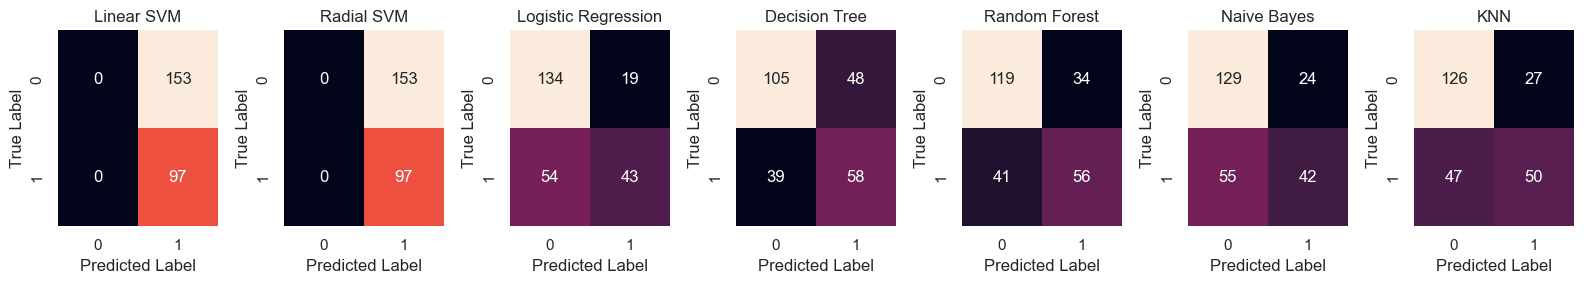

In [226]:
models = [svm_linear, svm_radial, log_reg, tree, random_tree, naive_baye, knn]
indexs = ['Linear SVM', 'Radial SVM', 'Logistic Regression',
          'Decision Tree', 'Random Forest', 'Naive Bayes', 'KNN']

fig, axes = plt.subplots(1, 7, figsize=(16, 3))

for model, index, ax in zip(models, indexs, np.ravel(axes)):
    y_pred = model.predict(X_validation)

    conf_matrix = confusion_matrix(y_validation, y_pred)

    sns.heatmap(conf_matrix, annot=True, fmt='d',
                cmap='rocket', cbar=False, ax=ax)
    ax.set_title(f'{index}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.tight_layout()
plt.show()

* SVM models tend to only choose either 0s or 1s. They should not be added together to Voting Classifier.

### ROC Curve
ROC curve shows best under the curve values for Radial SVM and KNN models, all models guess 0 better, than 1.

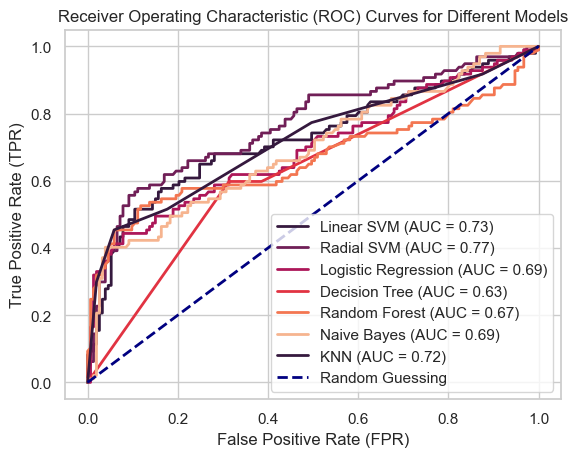

In [227]:
helpingtool.plot_roc_curve(
    svm_linear, X_validation_scaled, y_validation, 'Linear SVM')

helpingtool.plot_roc_curve(
    svm_radial, X_validation_scaled, y_validation, 'Radial SVM')

helpingtool.plot_roc_curve(log_reg, X_validation,
                           y_validation, 'Logistic Regression')

helpingtool.plot_roc_curve(tree, X_validation, y_validation, 'Decision Tree')

helpingtool.plot_roc_curve(random_tree, X_validation,
                           y_validation, 'Random Forest')

helpingtool.plot_roc_curve(naive_baye, X_validation,
                           y_validation, 'Naive Bayes')

helpingtool.plot_roc_curve(knn, X_validation, y_validation, 'KNN')


sns.set_palette("rocket")

plt.plot([0, 1], [0, 1], color='navy', lw=2,
         linestyle='--', label='Random Guessing')

plt.xlabel('False Positive Rate (FPR)')

plt.ylabel('True Positive Rate (TPR)')

plt.title('Receiver Operating Characteristic (ROC) Curves for Different Models')

plt.legend(loc='lower right')

plt.show()

## Cross Validation
Cross Validation is performed on all non-tuned models. Weights are used for Validation data.

In [228]:
X_train_with_weights = pd.concat([X_train, weights_train], axis=1)
X_train_with_weights_scaled = pd.concat(
    [pd.DataFrame(X_train_scaled, columns=X_train.columns), weights_train], axis=1)

In [229]:
kfold = KFold(n_splits=10, shuffle=True, random_state=40)

classifiers = [
    'Linear SVM', 'Radial SVM', 'Logistic Regression',
    'Decision Tree', 'Random Forest', 'Naive Bayes', 'KNN'
]

models = [
    LinearSVC(C=0.1, dual=False),
    SVC(kernel='rbf', C=1, gamma=0.1),
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GaussianNB(),
    KNeighborsClassifier()
]

cv_results = []
for index, model in enumerate(models):

    if model in ('Linear SVM', 'Radial SVM'):
        X_train_data = X_train_with_weights_scaled
    else:
        X_train_data = X_train_with_weights

    accuracy_scores = []
    precision_scores = []
    recall_scores = []  

    for train_index, val_index in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train_data.iloc[train_index], X_train_data.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        sample_weights_val = X_val_fold['Weights'].values

        X_train_fold = X_train_fold.drop(columns='Weights').copy()
        X_val_fold = X_val_fold.drop(columns='Weights').copy()

        model.fit(X_train_fold, y_train_fold)
        y_pred_val = model.predict(X_val_fold)

        accuracy = model.score(X_val_fold, y_val_fold,
                               sample_weight=sample_weights_val)
        precision = precision_score(y_val_fold, y_pred_val, average='binary',
                                    sample_weight=sample_weights_val, zero_division=1)
        recall = recall_score(y_val_fold, y_pred_val, average='binary',
                              sample_weight=sample_weights_val, zero_division=1)

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)

    cv_results.append({
        'Classifier': classifiers[index],
        'CV Mean Accuracy': np.mean(accuracy_scores),
        'CV Mean Precision': np.mean(precision_scores),
        'CV Mean Recall': np.mean(recall_scores),
        'Std Accuracy': np.std(accuracy_scores),
        'Accuracy': accuracy_scores,
        'Precision': precision_scores,
        'Recall': recall_scores,  
    })

model_info = pd.DataFrame(cv_results)

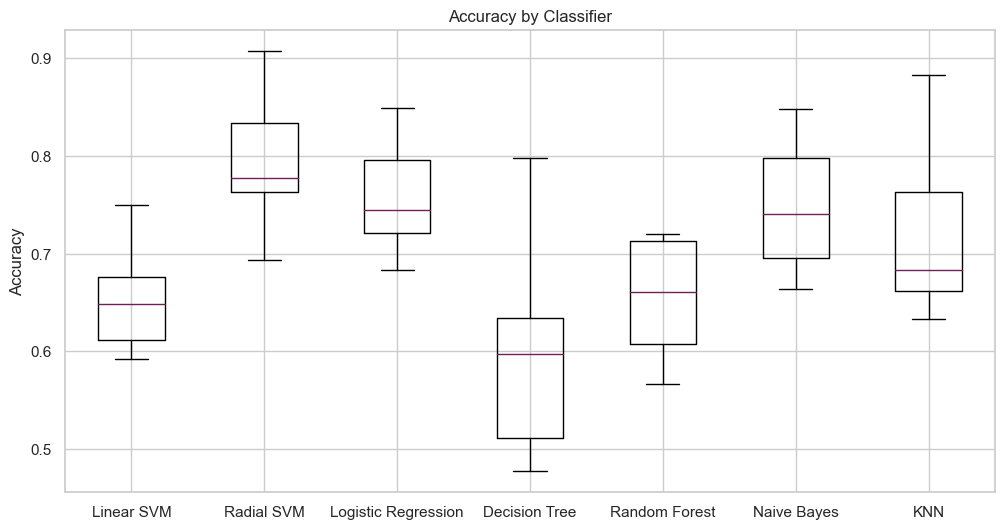

In [230]:
plt.subplots(figsize=(12, 6))
box_data = [acc for acc in model_info['Accuracy']]
box_plot = plt.boxplot(
    box_data, labels=model_info['Classifier'], showfliers=False)

plt.title('Accuracy by Classifier')
plt.ylabel('Accuracy')
plt.show()

* Linear SVM, Decision Tree, Random Forest have the lowest accuracy out of all models.<br>

Other metrics (Precision, Recall) can be seen below.

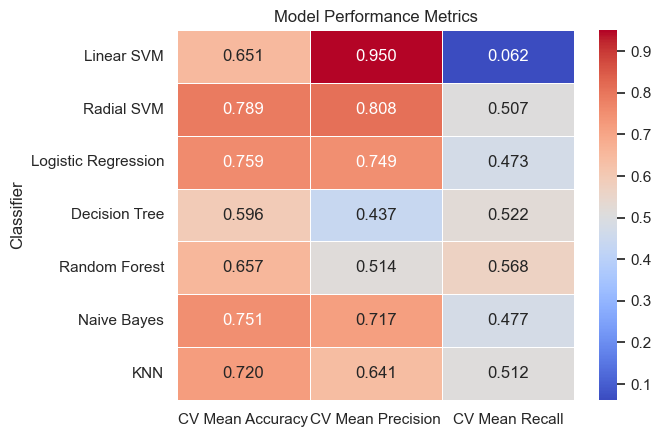

In [231]:
heatmap_data = model_info[['Classifier', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall']]

heatmap_data.set_index('Classifier', inplace=True)

sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5)
plt.title('Model Performance Metrics')
plt.show()

* Linear SVM got the highest Precision, but very low accuracy and recall. 
* Logistic Regression seams similar to Radial SVM. (Voting should not have too similar classifiers, so Logistic Regression won't be used)
* Decision Tree and Random Forest are suffering the most for overfitting.
* The rest models are good candidates for Voting.

### Confussion matrix
Plotting Confussion matrix for cross validated models shows different guessed that non-tuned model. This could be due to:
* Randomness in Data Splitting
* Model Variability
* Cross-Validation Averaging

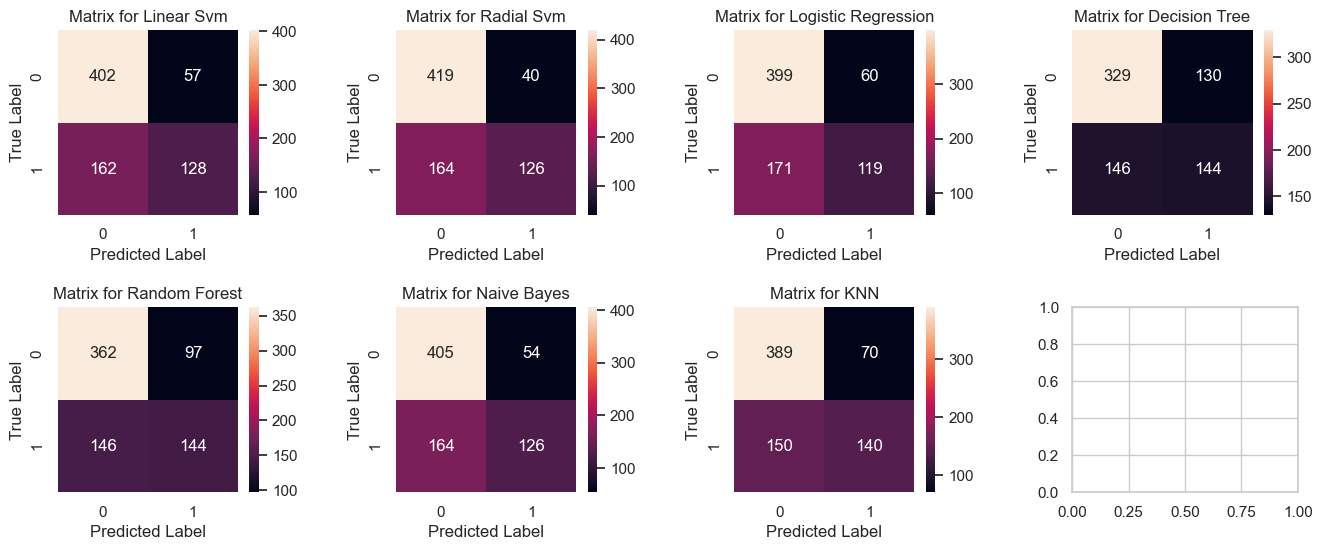

In [232]:
classifiers = ['Linear Svm', 'Radial Svm', 'Logistic Regression',
               'Decision Tree', 'Random Forest', 'Naive Bayes', 'KNN']


models = [
    LinearSVC(C=0.1, dual=False),
    SVC(kernel='rbf', C=1, gamma=0.1),
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GaussianNB(),
    KNeighborsClassifier()
]


f, ax = plt.subplots(2, 4, figsize=(16, 6))

ax = ax.flatten()


for i, (classifier_name, model) in enumerate(zip(classifiers, models)):
    if classifier_name in ('Linear Svm', 'Radial Svm'):
        X_train_data = X_train_scaled
    else:
        X_train_data = X_train

    y_pred = cross_val_predict(model, X_train_data, y_train, cv=10)
    cm = confusion_matrix(y_train, y_pred)
    sns.heatmap(cm, ax=ax[i], annot=True, fmt='2.0f')
    ax[i].set_title(f'Matrix for {classifier_name}')
    ax[i].set_xlabel('Predicted Label')
    ax[i].set_ylabel('True Label')

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

* SVM models have the biggest impact (before they guessed all 0s and 1s), but this is due to Data Imbalance for target variable.
* Radial SVM has one of lowest False Positives
* Naive Bayes and KNN got the highest scores on true negatives

## Hyper-Parameters Tuning
Tuning parameters for most promising models
### Radial Support Vector Machines

In [233]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf'))
])

param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [0.01, 0.1, 1, 10],
}

grid_search = GridSearchCV(
    estimator=svm_pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_svm_params = grid_search.best_params_
best_svm_model = grid_search.best_estimator_


helpingtool.accuracy_score_test(
    best_svm_model, X_validation, y_validation, weights_validation)

82.99

In [234]:
print("Best Parameters:", best_svm_params)

Best Parameters: {'svm__C': 100, 'svm__gamma': 0.01}


#### More tunning

In [235]:
param_grid = {
    'svm__C': [5, 10, 20, 30],
    'svm__gamma': [0.05, 0.1, 0.5],
}

grid_search = GridSearchCV(
    estimator=svm_pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_svm_params2 = grid_search.best_params_
best_svm_model2 = grid_search.best_estimator_


helpingtool.accuracy_score_test(
    best_svm_model2, X_validation, y_validation, weights_validation)

82.99

In [236]:
print("Best Parameters:", best_svm_params2)

Best Parameters: {'svm__C': 5, 'svm__gamma': 0.05}


* More tunning ended up with a completely different set of parameters. This could be due to Data Variability as GridSearchCV uses cross-validation and different data splits may lead to different optimal hyperparameter values.

### KNN

In [237]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': list(range(2, 11)),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5,
                           scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_knn_params = grid_search.best_params_
best_knn_model = grid_search.best_estimator_

helpingtool.accuracy_score_test(
    best_knn_model, X_validation, y_validation, weights_validation)

78.93

In [238]:
print("Best Parameters:", best_knn_params)

Best Parameters: {'knn__n_neighbors': 8, 'knn__p': 1, 'knn__weights': 'uniform'}


* KNN best n is 8 (which is pretty large) and will not be suitable for bagging.

### Decision Tree
Non tuned Decision Tree usualy perform bad. it's worth investing time for model tuning.

In [239]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dt_classifier', DecisionTreeClassifier())
])

param_grid = {
    'dt_classifier__criterion': ['gini', 'entropy'],
    'dt_classifier__splitter': ['best', 'random'],
    'dt_classifier__max_depth': [None, 5, 10, 15, 20],
    'dt_classifier__min_samples_split': [2, 5, 10, 20],
    'dt_classifier__min_samples_leaf': [1, 2, 4, 8],
    'dt_classifier__max_features': [None, 'sqrt', 'log2', 0.8, 0.6]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, error_score='raise')
grid_search.fit(X_train, y_train)

best_dt_params = grid_search.best_params_
best_dt_model = grid_search.best_estimator_

helpingtool.accuracy_score_test(
    best_dt_model, X_validation, y_validation, weights_validation)

84.01

In [240]:
print("Best Parameters:", best_dt_params)

Best Parameters: {'dt_classifier__criterion': 'gini', 'dt_classifier__max_depth': 5, 'dt_classifier__max_features': 0.8, 'dt_classifier__min_samples_leaf': 4, 'dt_classifier__min_samples_split': 20, 'dt_classifier__splitter': 'best'}


* After tuning, Decision Tree reached 84% in validation dataset. This is impressive as the last score was 65.74% before tuning.

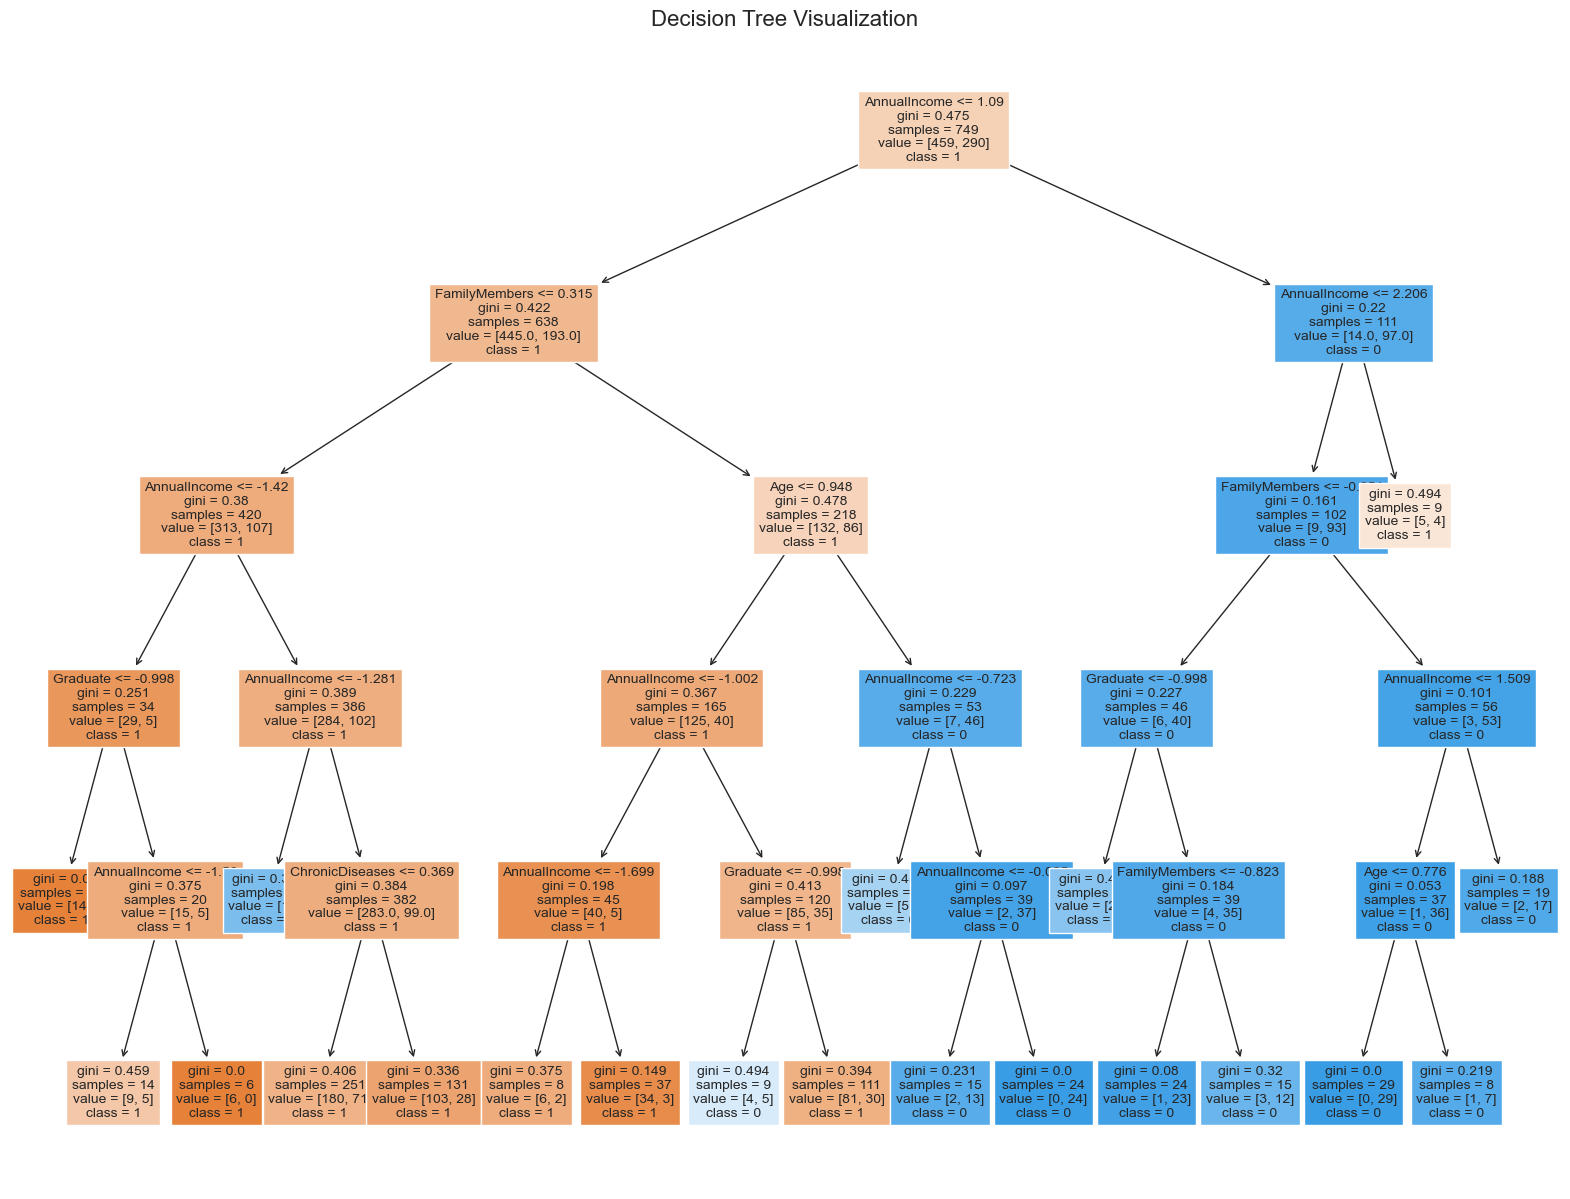

In [241]:
best_dt_model.fit(X_train, y_train)

plt.figure(figsize=(20, 15))
plot_tree(best_dt_model['dt_classifier'], feature_names=X.columns, class_names=y.astype(str).unique(), filled=True, fontsize=10)
plt.title('Decision Tree Visualization', fontsize=16)
plt.show()

* Feature importance in Decision Tree shows the most important feature - AnnualIncome. This wasn't obvious in the linear plotting (EDA part).

### Random Forest

In [242]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf_classifier', RandomForestClassifier())
])

param_grid = {
    'rf_classifier__n_estimators': [50, 100],
    'rf_classifier__max_depth': [None, 5, 10],
    'rf_classifier__min_samples_split': [2, 5],
    'rf_classifier__min_samples_leaf': [1, 4],
    'rf_classifier__max_features': ['sqrt', None, 0.8]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, error_score='raise')
grid_search.fit(X_train, y_train)

best_rf_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

helpingtool.accuracy_score_test(
    best_rf_model, X_validation, y_validation, weights_validation)

84.77

In [243]:
print("Best Parameters:", best_rf_params)

Best Parameters: {'rf_classifier__max_depth': 5, 'rf_classifier__max_features': 0.8, 'rf_classifier__min_samples_leaf': 1, 'rf_classifier__min_samples_split': 2, 'rf_classifier__n_estimators': 100}


Random forest had 73% before tuning, but now it reached 84%.

### Naive Bayers

In [244]:
naive_baye_pipeline = Pipeline([
    ('nb', GaussianNB())
])

param_grid_naive_baye = {
    'nb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6],
}

grid_search = GridSearchCV(
    naive_baye_pipeline, param_grid_naive_baye, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_naive_baye_params = grid_search.best_params_
best_naive_baye_model = grid_search.best_estimator_

helpingtool.accuracy_score_test(
    best_naive_baye_model, X_validation, y_validation, weights_validation)

74.37

In [245]:
print("Best Parameters:", best_naive_baye_params)

Best Parameters: {'nb__var_smoothing': 1e-09}


* Naive Bayers have not changed accuracy much 74-75% persists

## Ensembling
Ensembling combines various simple models to create one fine model.
* Voting Classifier - Voting takes different model and gives out the average prediction result based. 
* Bagging - Bagging takes the average of small partition output, it makes use of similar classifiers (which this study has many of). but Bagging works best with models with high variance (in this case - Decision Tree, Random Forest, KNN with small K performed the worst). This method won't be optimal
* Boosting - Boosting is a sequential learning of classifiers.

### Voting Classifier
Models used for Voting classifier were not that different, while the best performance is atchieved from different model.

In [246]:
random_state = 24

knn_classifier = KNeighborsClassifier(n_neighbors=6, p=2, weights='uniform')
svm_classifier = SVC(kernel='rbf', C=10, gamma=0.1, probability=True)
nb_classifier = GaussianNB(var_smoothing=1e-09)

voting_classifier = VotingClassifier(
    estimators=[
        ('knn', knn_classifier),
        ('svm', svm_classifier),
        ('nb', nb_classifier)
    ],
    voting='soft'
)

voting_classifier.fit(X_train_scaled, y_train)

y_validation_pred = voting_classifier.predict(X_validation_scaled)

accuracy = accuracy_score(y_validation, y_validation_pred)
print(f'Voting Classifier Accuracy: {accuracy:.4f}')

Voting Classifier Accuracy: 0.7680


In [247]:
cross = cross_val_score(voting_classifier, X_validation,
                        y_validation, cv=10, scoring="accuracy")

print('The cross validated score is', cross.mean())

The cross validated score is 0.732


### AdaBoost (Adaptive Boosting)
Boosting Naive Bayers as it has the most potential to get better.

In [248]:
adaboost_classifier_nb = AdaBoostClassifier(
    GaussianNB(), n_estimators=50, random_state=42, algorithm='SAMME')

adaboost_classifier_nb.fit(X_train, y_train)

helpingtool.accuracy_score_test(
    adaboost_classifier_nb, X_validation, y_validation, weights_validation)

74.37

# Validation on TEST dataset
Performing final check for never before used dataset Test. Voting has the worst performance out of all. The rest hyper-tuned models have similar accuracy.

In [249]:
models = [best_svm_model2, best_naive_baye_model, best_dt_model, best_rf_model,
          best_knn_model, voting_classifier, adaboost_classifier_nb]

indexs = ['Best SVM Radial', 'Best Naive Bayers', 'Best Decision Tree', 'Best Random Forest',
          'Best KNN', 'Voting', 'ADA Naive Bayers']


for model, index in zip(models, indexs):

    y_pred = model.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred, sample_weight=weights_test)


    model_name = index

    print(f'{model_name}: Accuracy Score = {acc_score:.4f}')

Best SVM Radial: Accuracy Score = 0.7942
Best Naive Bayers: Accuracy Score = 0.7603
Best Decision Tree: Accuracy Score = 0.8063
Best Random Forest: Accuracy Score = 0.8208
Best KNN: Accuracy Score = 0.7482
Voting: Accuracy Score = 0.3777
ADA Naive Bayers: Accuracy Score = 0.7603


### Confusion Matrix
* Voting Classifier  only chooses 0s. The chosen models were too similar for Voting to succeed.
* ADA boosted Naive Bayers performs the same as Hyper-Parameter tuned model

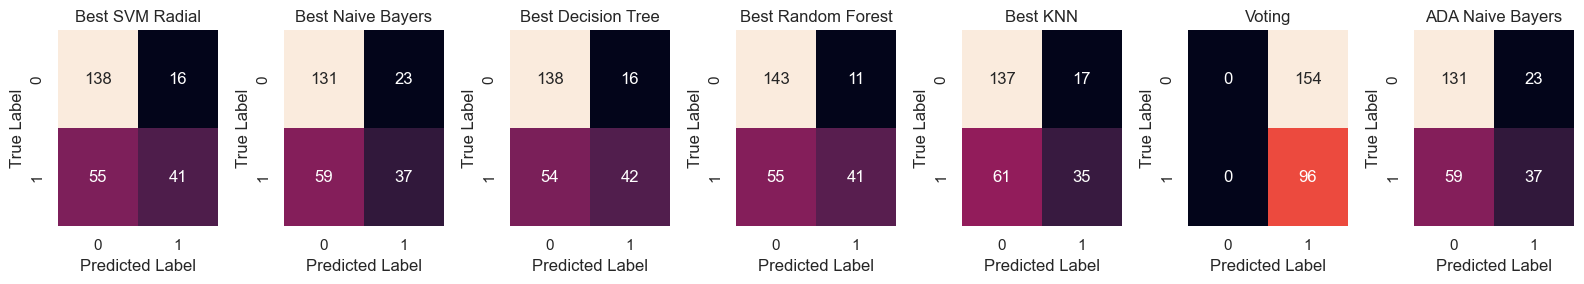

In [250]:
fig, axes = plt.subplots(1, 7, figsize=(16, 3))

for model, index, ax in zip(models, indexs, np.ravel(axes)):
    y_pred = model.predict(X_test)

    conf_matrix = confusion_matrix(y_test, y_pred)

    sns.heatmap(conf_matrix, annot=True, fmt='d',
                cmap='rocket', cbar=False, ax=ax)
    ax.set_title(f'{index}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.tight_layout()
plt.show()

### ROC Curve
ROC has best value for Radial SVM, with 0.7 score, which is not great, but not bad (as Random Guessing is 0.5)

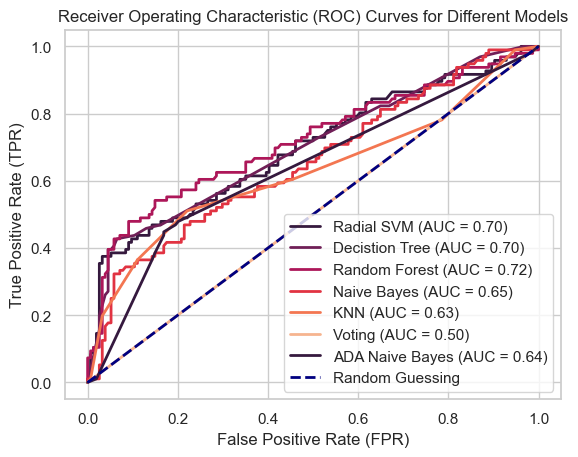

In [251]:
helpingtool.plot_roc_curve(best_svm_model2, X_test, y_test, 'Radial SVM')
helpingtool.plot_roc_curve(best_dt_model,
                           X_test, y_test, 'Decistion Tree')
helpingtool.plot_roc_curve(best_rf_model,
                           X_test, y_test, 'Random Forest')
helpingtool.plot_roc_curve(best_naive_baye_model,
                           X_test, y_test, 'Naive Bayes')
helpingtool.plot_roc_curve(best_knn_model, X_test, y_test, 'KNN')
helpingtool.plot_roc_curve(voting_classifier, X_test, y_test, 'Voting')
helpingtool.plot_roc_curve(adaboost_classifier_nb,
                           X_test, y_test, 'ADA Naive Bayes')

sns.set_palette("rocket")
plt.plot([0, 1], [0, 1], color='navy', lw=2,
         linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curves for Different Models')
plt.legend(loc='lower right')
plt.show()

Best Model is Radial SVM with Accuracy of 79%

# Conclusion
* Best Model is Radial SVM with Accuracy of 79%
* Voting and ADA Boosting was tried out but Voting Classifier suffered from too similar models
* Decision Tree and Random Forest seamed promising, but were heavily suffering from overfitting